In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import datetime, os

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


C:\Users\rayde\AppData\Local\Temp\ipykernel_24448\1473605421.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )


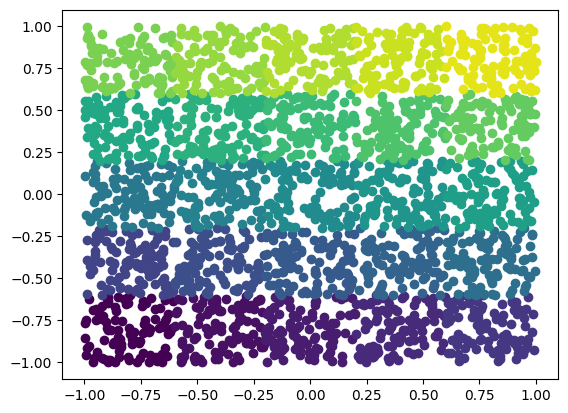

In [3]:
n_samples = 100
n_partitions = 5

random_samples = 2*np.random.rand(n_partitions**2, 2, n_samples)/n_partitions

# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, n_partitions, endpoint=False)
y = np.linspace(-1, 1, n_partitions, endpoint=False)
X,Y = np.meshgrid(x,y)
partitions = random_samples + np.stack([X.flatten(), Y.flatten()]).T[..., np.newaxis]
partitions = np.swapaxes(partitions, 1, 2)

cmap = plt.get_cmap('viridis') 

for i, part  in enumerate(partitions):
    plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )

In [4]:
# Define vector function with three scalar functions
def f_sum_decomposable(x):
    x1, x2 = x[:,0], x[:,1]
    #return three different functions using both x1 and x2. the functions should be difficult to predict
    #f1 should have multiple waves
    f1 = np.sin(2*x1) + np.sin(4*x2)
    #f2 should be a wavy line
    f2 = np.cos(2*x1) + np.cos(np.pi*x2)
    #f3 should be a circle
    f3 = np.sqrt(1 - x1**2) + np.tanh(x2)
    #return them as a stack
    return np.stack([f1, f2, f3], axis=1)   



[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


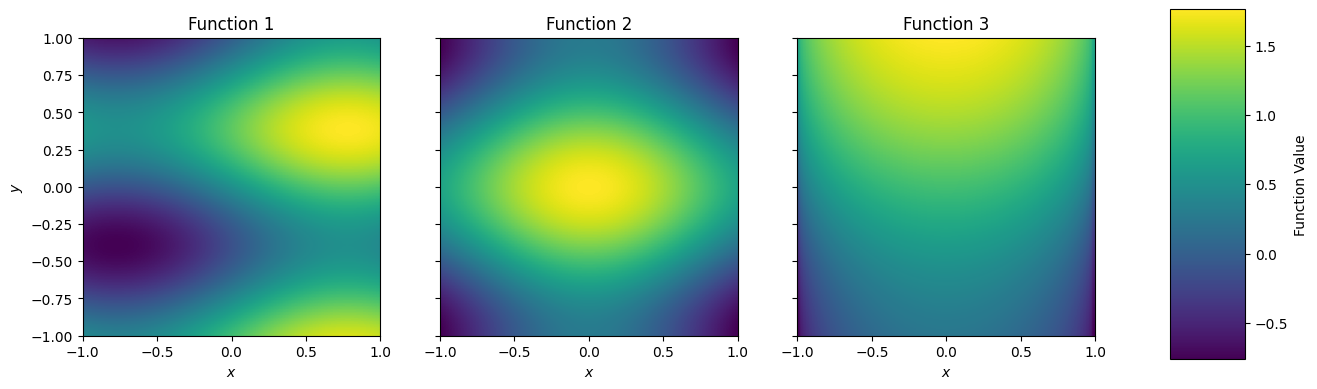

In [5]:
# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [7]:
#using pytorch to create the neural network that will be used to approximate the three functions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Create the neural network
model = Net().to(device)

# Define the optimizer sgd
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Create a DataLoader object
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
dataset = TensorDataset(coordinates_tensor)
dataloader = DataLoader(dataset, batch_size=100)

# Train the neural network
model.train()
n_epochs = 200
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = data[0].to(device)
        outputs = model(inputs)
        targets = torch.tensor(f(inputs.cpu().numpy()), dtype=torch.float32).to(device)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} Loss: {loss.item()}')




Epoch 0/200 Loss: 1.0597331523895264
Epoch 10/200 Loss: 0.8655591607093811
Epoch 20/200 Loss: 0.8141025304794312
Epoch 30/200 Loss: 0.729758083820343
Epoch 40/200 Loss: 0.6375091671943665
Epoch 50/200 Loss: 0.5588406324386597
Epoch 60/200 Loss: 0.4907582700252533
Epoch 70/200 Loss: 0.43116018176078796
Epoch 80/200 Loss: 0.3808457553386688
Epoch 90/200 Loss: 0.3411448299884796
Epoch 100/200 Loss: 0.3124851584434509
Epoch 110/200 Loss: 0.2930641174316406
Epoch 120/200 Loss: 0.2801467478275299
Epoch 130/200 Loss: 0.27100449800491333
Epoch 140/200 Loss: 0.26353463530540466
Epoch 150/200 Loss: 0.25632792711257935
Epoch 160/200 Loss: 0.24873018264770508
Epoch 170/200 Loss: 0.24059875309467316
Epoch 180/200 Loss: 0.23182421922683716
Epoch 190/200 Loss: 0.22233164310455322


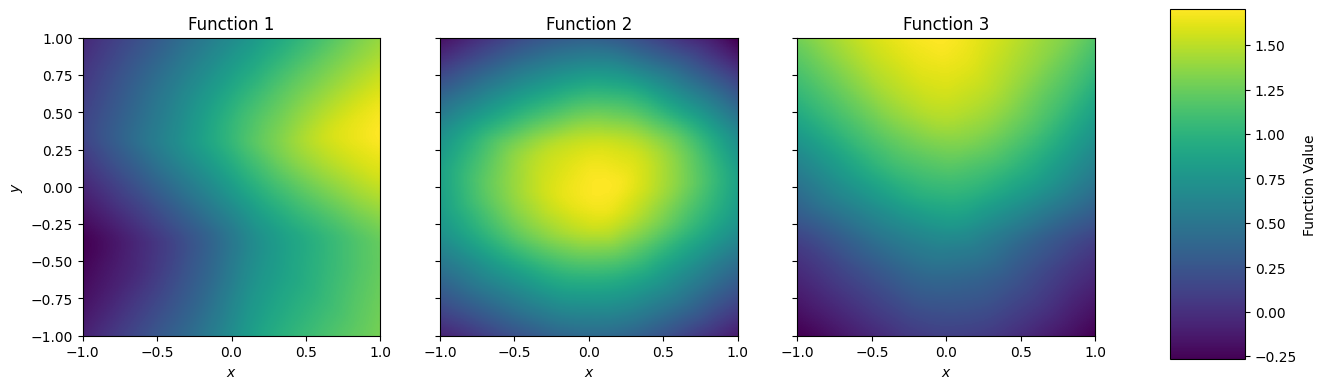

In [8]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
model.eval()
outputs = model(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [9]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = model(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')



Mean MAE: 0.1827544293456556 +/- 0.007407355924312363
Mean MSE: 0.06714709564969512 +/- 0.0046698907132883645


[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


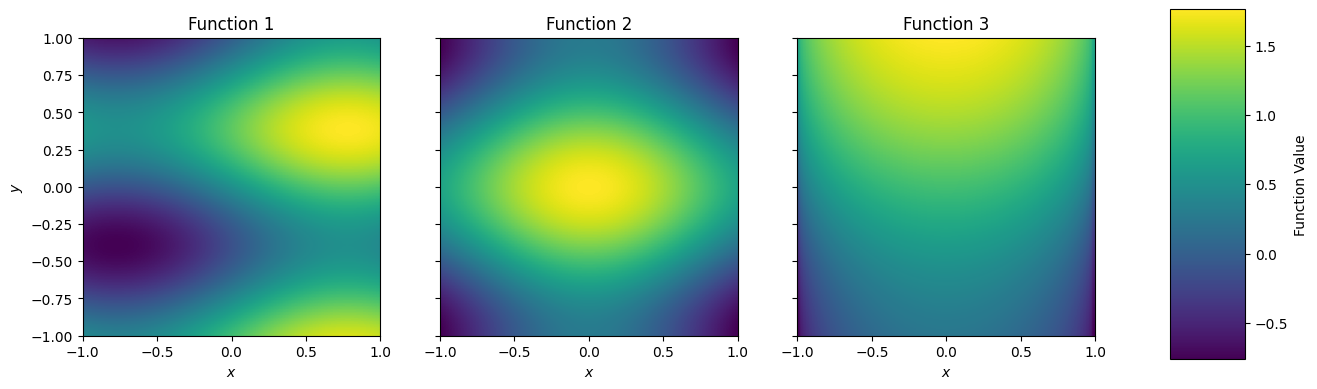

In [10]:
# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


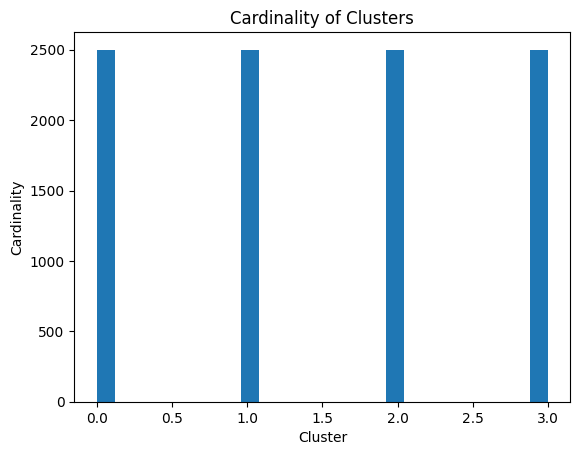

In [11]:
#using kmeans, partition the coordinates into 25 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(coordinates)
clusters = kmeans.labels_

#plot the cardinality of each cluster
plt.hist(clusters, bins=25)
plt.xlabel('Cluster')
plt.ylabel('Cardinality')
plt.title('Cardinality of Clusters')
plt.show()

#make a df containing the coordinates and the cluster they belong to
df = pd.DataFrame(coordinates, columns=['x', 'y'])
df['cluster'] = clusters


In [12]:


#Define the custom optimizer
class COSGD(optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(COSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-group['lr'], d_p)
        
        return loss

def flatten_grads(grads):
    grads = torch.cat([grad.view(-1) for grad in grads])
    return grads

def unflatten_grads(flattened_grads, model):
    grads = []
    start = 0
    for param in model.parameters():
        end = start + param.numel()
        grads.append(flattened_grads[start:end].view(param.size()))
        start = end
    return grads

def sort_grads(grads, sort_order=True):
    avg_abs = [torch.mean(torch.abs(grad)).item() for grad in grads]
    order = sorted(range(len(avg_abs)), key=lambda i: avg_abs[i], reverse=sort_order)
    return order

def unsort_grads(grads, order):
    unsorted_grads = [grads[i] for i in order]
    return unsorted_grads

def orthogonalize_grads(grads):
    flattened_grads = [flatten_grads(cluster_grads) for cluster_grads in grads]

    #sort the vectors by average absolute value in descending order
    order = sort_grads(flattened_grads)
    flattened_grads = [flattened_grads[i] for i in order]

    #now we have a set of vectors, we can perform the gram schmidt process
    ortho_grads = []
    for i, grad in enumerate(flattened_grads):
        for j in range(i):
            #subtract the projection of the current vector onto the previous vectors
            if torch.norm(ortho_grads[j]) != 0:
                grad = grad - (grad @ ortho_grads[j]) / (ortho_grads[j] @ ortho_grads[j]) * ortho_grads[j]
        ortho_grads.append(grad)
    #sort the vectors back to their original order
    ortho_grads = unsort_grads(ortho_grads, order)
    return ortho_grads

In [13]:
#prepare dataloaders for each cluster
#loop size is equal to the min cardinality of a cluster divided by the batch size
max_cardinality = df['cluster'].value_counts().max()
batch_size = 100
num_mini_batches = max_cardinality // batch_size

dataloaders = []
for i in range(4):
    cluster = df[df['cluster'] == i]
    cluster_tensor = torch.tensor(cluster[['x', 'y']].values, dtype=torch.float32).to(device)
    dataset = TensorDataset(cluster_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataloaders.append(dataloader)

def train_model_cosgd(model, optimizer, dataloaders, loss_function, epochs):
    criterion = loss_function
    model.train()

    for epoch in range(epochs):

        clustered_mini_batches = [[] for _ in range(num_mini_batches+1)]
        for dataloader in dataloaders:
            for i, data in enumerate(dataloader):
                clustered_mini_batches[i].append(data[0])

        #print the shape of clustered_mini_batches
        #print([len(mini_batch) for mini_batch in clustered_mini_batches])

        #print the data in each mini batch
        # for i, mini_batch in enumerate(clustered_mini_batches):
        #     print('Mini-Batch set ', i)
        #     for data in mini_batch:
        #         print(len(data))

        #now we have all the relevant data in each mini batch, we need to loop through the mini batches and apply the normal algorithm
        for i, mini_batch in enumerate(clustered_mini_batches):
            grad_updates = []
            optimizer.zero_grad()
            for j, data in enumerate(mini_batch):
                outputs = model(data)
                targets = torch.tensor(f(data.cpu().numpy()), dtype=torch.float32).to(device)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                grad_updates.append([param.grad.data.clone() for param in model.parameters()])
                #print(f'Mini-Batch {i+1}/{len(clustered_mini_batches)}', f'Cluster {j+1}/{len(mini_batch)}', 'Loss :', loss.item())

            if len(grad_updates) == 0:
                continue
            #orthogonalize the gradients
            # print('grad updates before orthogonalization')
            # print(grad_updates)
            grad_updates = orthogonalize_grads(grad_updates)
            # print('grad updates after orthogonalization')
            # print(grad_updates)
            #sum the gradients element wise
            grad_update = torch.sum(torch.stack(grad_updates), dim=0)
            # print('grad update after sum')
            # print(grad_update)
            #unflatten the gradient
            grad_update = unflatten_grads(grad_update, model)
            # print('grad update after unflatten')
            # print(grad_update)
            #set the model parameters to the sum of the gradients
            for param, grad in zip(model.parameters(), grad_update):
                param.grad = grad
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs}', 'Loss :', loss.item())

                
    return model


In [14]:
#using pytorch to create the neural network that will be used to approximate the three functions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# Create the neural network
COSGDmodel = Net().to(device)
#define the optimizer
optimizer = COSGD(COSGDmodel.parameters(), lr=0.001)
#define the loss function
criterion = nn.MSELoss()
# Train the neural network
COSGDmodel = train_model_cosgd(COSGDmodel, optimizer, dataloaders, criterion, 200) 


Epoch 1/200 Loss : 0.5096843242645264
Epoch 2/200 Loss : 0.47398629784584045
Epoch 3/200 Loss : 0.4094768762588501
Epoch 4/200 Loss : 0.536818265914917
Epoch 5/200 Loss : 0.338212788105011
Epoch 6/200 Loss : 0.42980632185935974
Epoch 7/200 Loss : 0.4545214772224426
Epoch 8/200 Loss : 0.37975168228149414
Epoch 9/200 Loss : 0.4401283860206604
Epoch 10/200 Loss : 0.47096389532089233
Epoch 11/200 Loss : 0.44381722807884216
Epoch 12/200 Loss : 0.43311476707458496
Epoch 13/200 Loss : 0.4439951181411743
Epoch 14/200 Loss : 0.4618207812309265
Epoch 15/200 Loss : 0.43733763694763184
Epoch 16/200 Loss : 0.35493186116218567
Epoch 17/200 Loss : 0.4379979074001312
Epoch 18/200 Loss : 0.394492506980896
Epoch 19/200 Loss : 0.46734142303466797
Epoch 20/200 Loss : 0.4250675439834595
Epoch 21/200 Loss : 0.3346952199935913
Epoch 22/200 Loss : 0.33341553807258606
Epoch 23/200 Loss : 0.36853039264678955
Epoch 24/200 Loss : 0.40734049677848816
Epoch 25/200 Loss : 0.34604376554489136
Epoch 26/200 Loss : 0.34

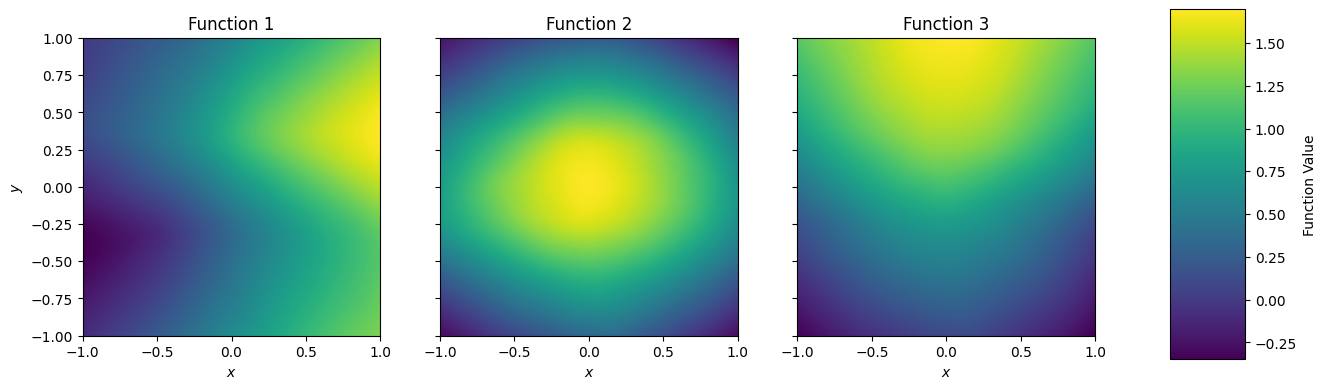

In [19]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
COSGDmodel.eval()
outputs = COSGDmodel(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"

titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function_cosgd.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [20]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = COSGDmodel(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')

Mean MAE: 0.16689084753639866 +/- 0.0050399550802297625
Mean MSE: 0.05228249935147692 +/- 0.0037232272289038004
